In [1]:
import numpy as np
import torch


import json
from torch.utils.data import DataLoader
from torch.optim import SGD, AdamW
from torch import nn

from sklearn.feature_extraction.text import TfidfVectorizer
from statistics import mean

In [2]:
import utils_generic as generic
import rrnn_modelo as rrnn
import logistic_regresion as lr
import singletask_dep as st
import train

In [3]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
encoding_type = 'relative'

# Datos ConvAI2

In [4]:
with open('Datasets\ConvAI2\convai2_complete.json','r') as f:
    data = json.load(f)

In [5]:
convai_train = data['train']
convai_val = data['validation']

vocab_dep = st.Vocabulary(data['train'],encoding_type)

vectorizer = TfidfVectorizer()

vectorizer.fit_transform(list(convai_train.keys()))

convai_train_token = generic.tokenize_dataset_with_dependencies_rrnn2(convai_train,['about','to','as'],vocab=vocab_dep,tfidf=vectorizer) 
convai_val_token = generic.tokenize_dataset_with_dependencies_rrnn2(convai_val,['about','to','as'],vocab=vocab_dep,tfidf=vectorizer) 

In [6]:
convai_train_dataset = {}
for task in ['to','as','about']:
    convai_train_dataset[task] = rrnn.DatasetSingleTaskRRNN(convai_train_token,task,eval=False,tfidf=True,deps=True)

In [7]:
convai_val_dataset = {}
for task in ['to','as','about']:
    convai_val_dataset[task] = rrnn.DatasetSingleTaskRRNN(convai_val_token,task,eval=False,tfidf=True,deps=True)

# Datos md_gender

In [8]:
with open('Datasets\md_gender\md_complete.json','r',encoding="utf8") as f:
    md_data = json.load(f)

In [9]:
md_tokenized = generic.tokenize_dataset_with_dependencies_rrnn2(md_data,['about','to','as'],vocab=vocab_dep,tfidf=vectorizer) 


md_dataset = {}
for task in ['to','as','about']:
    md_dataset[task] = rrnn.DatasetSingleTaskRRNN(md_tokenized,task,eval=True,tfidf=True,deps=True)

# Creación dataloaders

In [10]:
dl_train = {}
for task in ['to','as','about']:
    dl_train[task] = DataLoader(convai_train_dataset[task],batch_size=128,shuffle=True,collate_fn=rrnn.collate_fn_dep)

In [11]:
dl_val = {}
for task in ['to','as','about']:
    dl_val[task] = DataLoader(convai_val_dataset[task],batch_size=128,shuffle=True,collate_fn=rrnn.collate_fn_dep)

In [12]:
dl_eval = {}
for task in ['to','as','about']:
    dl_eval[task] = DataLoader(md_dataset[task],batch_size=128,shuffle=False,collate_fn=rrnn.collate_fn_dep)

# ABOUT

In [13]:
max_sequence_len = 15088
learning_rate = 5e-5
num_epochs = 100

global_metrics = {'about':{'global':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'male':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'female':{'recall': [], 'precision': [],'f1': [], 'accuracy': []}},
                    'as':{'global':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'male':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'female':{'recall': [], 'precision': [],'f1': [], 'accuracy': []}},
                    'to':{'global':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'male':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'female':{'recall': [], 'precision': [],'f1': [], 'accuracy': []}}}

In [14]:
model = lr.LogisticRegressionDep(sequence_max_len=max_sequence_len,lstm_hidden_dim=128,dep_vocab=vocab_dep)

  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6805996086954655 	 Validation loss: 0.678613393993701 	 
  1%|          | 574/57400 [00:14<29:06, 32.54it/s]
Epoch 2 	 Training loss: 0.6706019095842847 	 Validation loss: 0.6684739478563858 	 
  2%|▏         | 1148/57400 [00:26<37:56, 24.71it/s]
Epoch 3 	 Training loss: 0.665233269904964 	 Validation loss: 0.6643980175761853 	 
  3%|▎         | 1722/57400 [00:35<13:39, 67.97it/s]
Epoch 4 	 Training loss: 0.6615440039684548 	 Validation loss: 0.6606465153774973 	 
  4%|▍         | 2296/57400 [00:44<13:15, 69.28it/s]
Epoch 5 	 Training loss: 0.6581716255028489 	 Validation loss: 0.6584157903315657 	 
  5%|▌         | 2870/57400 [00:53<12:36, 72.04it/s]
Epoch 6 	 Training loss: 0.655212731726909 	 Validation loss: 0.654881304603512 	 
  6%|▌         | 3444/57400 [01:02<12:53, 69.71it/s]
Epoch 7 	 Training loss: 0.6522536673404614 	 Validation loss: 0.6519444190849693 	 
  7%|▋         | 4018/57400 [01:11<12:41, 70.11it/s]
Epoch 8 	 Training loss: 0.649450246049

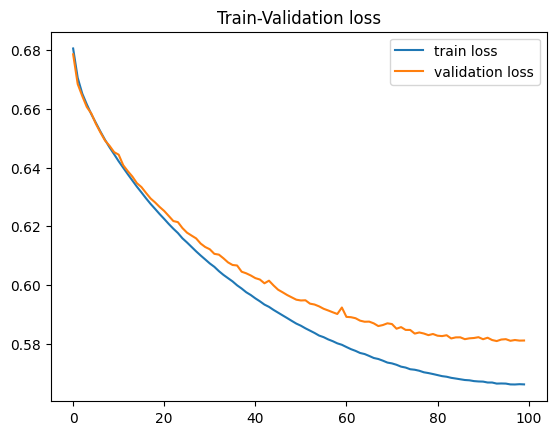

In [15]:
model = lr.LogisticRegressionDep(sequence_max_len=max_sequence_len,lstm_hidden_dim=128,dep_vocab=vocab_dep).to(device)
optimizer = AdamW(model.parameters(), lr=learning_rate,weight_decay=0.1)


save_path=f'm1_{encoding_type}_lr_about1'
train.train_function(model,num_epochs,dl_train['about'],optimizer,early_stop=10,dl_val=dl_val['about'],save_path=save_path,es_threshold=0)

In [16]:
model = lr.LogisticRegressionDep(sequence_max_len=max_sequence_len,lstm_hidden_dim=128,dep_vocab=vocab_dep).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
   
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = train.eval_func(model,dl_eval[task])
    generic.update_global_metric(metric_result,global_metrics[task]['global'])
    print(f"GLOBAL: {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='male')
    generic.update_global_metric(metric_result,global_metrics[task]['male'])
    print(f"MALE {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='female')
    generic.update_global_metric(metric_result,global_metrics[task]['female'])
    print(f"FEMALE {metric_result}",'\n')

Evaluación en el conjunto el conjunto about
GLOBAL: {'recall': 0.5905612244897959, 'precision': 0.5905612244897959, 'f1': 0.5905612244897959, 'accuracy': 0.5905612244897959}
MALE {'recall': 0.8619791666666666, 'precision': 0.8619791666666666, 'f1': 0.8619791666666666, 'accuracy': 0.8619791666666666}
FEMALE {'recall': 0.33, 'precision': 0.33, 'f1': 0.33, 'accuracy': 0.33} 

Evaluación en el conjunto el conjunto to
GLOBAL: {'recall': 0.5467171717171717, 'precision': 0.5467171717171717, 'f1': 0.5467171717171717, 'accuracy': 0.5467171717171717}
MALE {'recall': 0.7931873479318735, 'precision': 0.7931873479318735, 'f1': 0.7931873479318735, 'accuracy': 0.7931873479318735}
FEMALE {'recall': 0.28083989501312334, 'precision': 0.28083989501312334, 'f1': 0.28083989501312334, 'accuracy': 0.28083989501312334} 

Evaluación en el conjunto el conjunto as
GLOBAL: {'recall': 0.5619295958279009, 'precision': 0.5619295958279009, 'f1': 0.5619295958279009, 'accuracy': 0.5619295958279009}
MALE {'recall': 0.82

  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.680803924383602 	 Validation loss: 0.6765707054380643 	 
  1%|          | 574/57400 [00:08<13:25, 70.56it/s]
Epoch 2 	 Training loss: 0.6696006641155337 	 Validation loss: 0.6671314714318615 	 
  2%|▏         | 1148/57400 [00:17<14:02, 66.79it/s]
Epoch 3 	 Training loss: 0.6643589655073677 	 Validation loss: 0.6619647508960659 	 
  3%|▎         | 1722/57400 [00:26<13:09, 70.53it/s]
Epoch 4 	 Training loss: 0.6605340929812256 	 Validation loss: 0.6595658861984641 	 
  4%|▍         | 2296/57400 [00:35<12:41, 72.35it/s]
Epoch 5 	 Training loss: 0.6574429019195277 	 Validation loss: 0.6564794799028817 	 
  5%|▌         | 2870/57400 [00:44<13:07, 69.28it/s]
Epoch 6 	 Training loss: 0.6543845731622251 	 Validation loss: 0.6545889569541156 	 
  6%|▌         | 3444/57400 [00:53<12:53, 69.71it/s]
Epoch 7 	 Training loss: 0.6515065675620834 	 Validation loss: 0.6518937915058459 	 
  7%|▋         | 4018/57400 [01:02<13:08, 67.74it/s]
Epoch 8 	 Training loss: 0.648906869

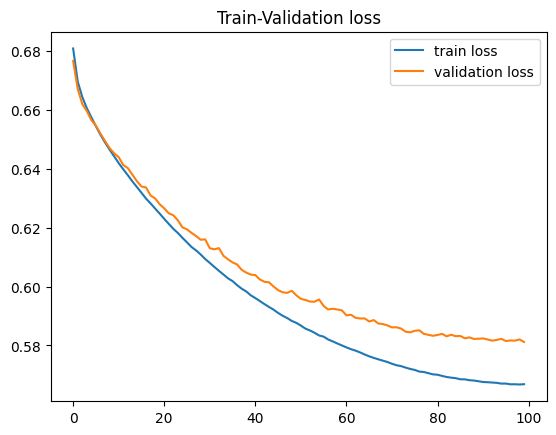

In [17]:
model = lr.LogisticRegressionDep(sequence_max_len=max_sequence_len,lstm_hidden_dim=128,dep_vocab=vocab_dep).to(device)
optimizer = AdamW(model.parameters(), lr=learning_rate,weight_decay=0.1)


save_path=f'm1_{encoding_type}_lr_about2'
train.train_function(model,num_epochs,dl_train['about'],optimizer,early_stop=10,dl_val=dl_val['about'],save_path=save_path,es_threshold=0)

In [18]:
model = lr.LogisticRegressionDep(sequence_max_len=max_sequence_len,lstm_hidden_dim=128,dep_vocab=vocab_dep).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
   
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = train.eval_func(model,dl_eval[task])
    generic.update_global_metric(metric_result,global_metrics[task]['global'])
    print(f"GLOBAL: {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='male')
    generic.update_global_metric(metric_result,global_metrics[task]['male'])
    print(f"MALE {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='female')
    generic.update_global_metric(metric_result,global_metrics[task]['female'])
    print(f"FEMALE {metric_result}",'\n')

Evaluación en el conjunto el conjunto about
GLOBAL: {'recall': 0.6045918367346939, 'precision': 0.6045918367346939, 'f1': 0.6045918367346939, 'accuracy': 0.6045918367346939}
MALE {'recall': 0.8776041666666666, 'precision': 0.8776041666666666, 'f1': 0.8776041666666666, 'accuracy': 0.8776041666666666}
FEMALE {'recall': 0.3425, 'precision': 0.3425, 'f1': 0.3425, 'accuracy': 0.3425} 

Evaluación en el conjunto el conjunto to
GLOBAL: {'recall': 0.5542929292929293, 'precision': 0.5542929292929293, 'f1': 0.5542929292929293, 'accuracy': 0.5542929292929293}
MALE {'recall': 0.8102189781021898, 'precision': 0.8102189781021898, 'f1': 0.8102189781021898, 'accuracy': 0.8102189781021898}
FEMALE {'recall': 0.2782152230971129, 'precision': 0.2782152230971129, 'f1': 0.2782152230971129, 'accuracy': 0.2782152230971129} 

Evaluación en el conjunto el conjunto as
GLOBAL: {'recall': 0.5697522816166884, 'precision': 0.5697522816166884, 'f1': 0.5697522816166884, 'accuracy': 0.5697522816166884}
MALE {'recall': 

  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6808470236299761 	 Validation loss: 0.6801847229569645 	 
  1%|          | 574/57400 [00:08<13:13, 71.66it/s]
Epoch 2 	 Training loss: 0.6723502417474674 	 Validation loss: 0.669671020265353 	 
  2%|▏         | 1148/57400 [00:17<13:08, 71.32it/s]
Epoch 3 	 Training loss: 0.6646406102263553 	 Validation loss: 0.6650033017336312 	 
  3%|▎         | 1722/57400 [00:26<13:13, 70.21it/s]
Epoch 4 	 Training loss: 0.6604387287686511 	 Validation loss: 0.6619122351630259 	 
  4%|▍         | 2296/57400 [00:35<13:22, 68.63it/s]
Epoch 5 	 Training loss: 0.6572770971662076 	 Validation loss: 0.6573740809650744 	 
  5%|▌         | 2870/57400 [00:44<13:23, 67.84it/s]
Epoch 6 	 Training loss: 0.654597156139201 	 Validation loss: 0.6550958237405551 	 
  6%|▌         | 3444/57400 [00:53<12:31, 71.82it/s]
Epoch 7 	 Training loss: 0.6517655571163323 	 Validation loss: 0.65271043676441 	 
  7%|▋         | 4018/57400 [01:02<12:36, 70.54it/s]
Epoch 8 	 Training loss: 0.649326355615

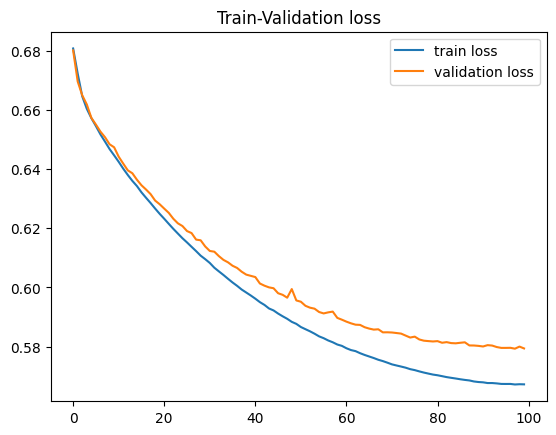

In [19]:
model = lr.LogisticRegressionDep(sequence_max_len=max_sequence_len,lstm_hidden_dim=128,dep_vocab=vocab_dep).to(device)
optimizer = AdamW(model.parameters(), lr=learning_rate,weight_decay=0.1)


save_path=f'm1_{encoding_type}_lr_about3'
train.train_function(model,num_epochs,dl_train['about'],optimizer,early_stop=10,dl_val=dl_val['about'],save_path=save_path,es_threshold=0)

In [20]:
model = lr.LogisticRegressionDep(sequence_max_len=max_sequence_len,lstm_hidden_dim=128,dep_vocab=vocab_dep).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
   
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = train.eval_func(model,dl_eval[task])
    generic.update_global_metric(metric_result,global_metrics[task]['global'])
    print(f"GLOBAL: {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='male')
    generic.update_global_metric(metric_result,global_metrics[task]['male'])
    print(f"MALE {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='female')
    generic.update_global_metric(metric_result,global_metrics[task]['female'])
    print(f"FEMALE {metric_result}",'\n')

Evaluación en el conjunto el conjunto about
GLOBAL: {'recall': 0.6071428571428571, 'precision': 0.6071428571428571, 'f1': 0.6071428571428571, 'accuracy': 0.6071428571428571}
MALE {'recall': 0.8776041666666666, 'precision': 0.8776041666666666, 'f1': 0.8776041666666666, 'accuracy': 0.8776041666666666}
FEMALE {'recall': 0.3475, 'precision': 0.3475, 'f1': 0.3475, 'accuracy': 0.3475} 

Evaluación en el conjunto el conjunto to
GLOBAL: {'recall': 0.5568181818181818, 'precision': 0.5568181818181818, 'f1': 0.5568181818181818, 'accuracy': 0.5568181818181818}
MALE {'recall': 0.8248175182481752, 'precision': 0.8248175182481752, 'f1': 0.8248175182481752, 'accuracy': 0.8248175182481752}
FEMALE {'recall': 0.2677165354330709, 'precision': 0.2677165354330709, 'f1': 0.2677165354330709, 'accuracy': 0.2677165354330709} 

Evaluación en el conjunto el conjunto as
GLOBAL: {'recall': 0.560625814863103, 'precision': 0.560625814863103, 'f1': 0.560625814863103, 'accuracy': 0.560625814863103}
MALE {'recall': 0.80

In [21]:

print('Métricas globales: \n')

for task in ['about','to','as']:
    print('\n',task)
    print('Resultado global:',{m:mean(values) for m,values in global_metrics[task]['global'].items()})
    print(f'Métricas etiqueta male:',{m:mean(values) for m,values in global_metrics[task]['male'].items()})
    print('Métricas etiqueta female: ',{m:mean(values) for m,values in global_metrics[task]['female'].items()})


Métricas globales: 


 about
Resultado global: {'recall': 0.6007653061224489, 'precision': 0.6007653061224489, 'f1': 0.6007653061224489, 'accuracy': 0.6007653061224489}
Métricas etiqueta male: {'recall': 0.8723958333333333, 'precision': 0.8723958333333333, 'f1': 0.8723958333333333, 'accuracy': 0.8723958333333333}
Métricas etiqueta female:  {'recall': 0.34, 'precision': 0.34, 'f1': 0.34, 'accuracy': 0.34}

 to
Resultado global: {'recall': 0.5526094276094276, 'precision': 0.5526094276094276, 'f1': 0.5526094276094276, 'accuracy': 0.5526094276094276}
Métricas etiqueta male: {'recall': 0.8094079480940795, 'precision': 0.8094079480940795, 'f1': 0.8094079480940795, 'accuracy': 0.8094079480940795}
Métricas etiqueta female:  {'recall': 0.2755905511811024, 'precision': 0.2755905511811024, 'f1': 0.2755905511811024, 'accuracy': 0.2755905511811024}

 as
Resultado global: {'recall': 0.5641025641025641, 'precision': 0.5641025641025641, 'f1': 0.5641025641025641, 'accuracy': 0.5641025641025641}
Métrica

# TO

In [22]:
max_sequence_len = 15088
learning_rate = 5e-5
num_epochs = 100

global_metrics = {'about':{'global':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'male':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'female':{'recall': [], 'precision': [],'f1': [], 'accuracy': []}},
                    'as':{'global':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'male':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'female':{'recall': [], 'precision': [],'f1': [], 'accuracy': []}},
                    'to':{'global':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'male':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'female':{'recall': [], 'precision': [],'f1': [], 'accuracy': []}}}

  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6931697985851806 	 Validation loss: 0.6930240140122882 	 
  1%|          | 574/57400 [00:09<15:07, 62.63it/s]
Epoch 2 	 Training loss: 0.6930322967962936 	 Validation loss: 0.6927979143999391 	 
  2%|▏         | 1148/57400 [00:20<14:52, 63.05it/s]
Epoch 3 	 Training loss: 0.693045220204762 	 Validation loss: 0.6926811731467812 	 
  3%|▎         | 1722/57400 [00:30<14:27, 64.20it/s]
Epoch 4 	 Training loss: 0.6929205488867876 	 Validation loss: 0.693110852928485 	 

1 epoch without improvement
  4%|▍         | 2296/57400 [00:40<14:51, 61.84it/s]
Epoch 5 	 Training loss: 0.6928440345912029 	 Validation loss: 0.6928724717285674 	 

2 epoch without improvement
  5%|▌         | 2870/57400 [00:50<14:28, 62.82it/s]
Epoch 6 	 Training loss: 0.6927762192508485 	 Validation loss: 0.6930678779796019 	 

3 epoch without improvement
  6%|▌         | 3444/57400 [01:01<14:07, 63.66it/s]
Epoch 7 	 Training loss: 0.6927351487430546 	 Validation loss: 0.6934645337573553 	 

4 

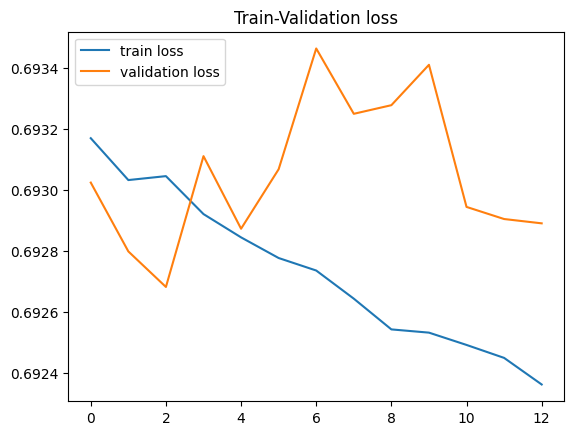

In [23]:
model = lr.LogisticRegressionDep(sequence_max_len=max_sequence_len,lstm_hidden_dim=128,dep_vocab=vocab_dep).to(device)
optimizer = AdamW(model.parameters(), lr=learning_rate,weight_decay=0.1)


save_path=f'm1_{encoding_type}_lr_to1'
train.train_function(model,num_epochs,dl_train['to'],optimizer,early_stop=10,dl_val=dl_val['to'],save_path=save_path,es_threshold=0)

In [24]:
model = lr.LogisticRegressionDep(sequence_max_len=max_sequence_len,lstm_hidden_dim=128,dep_vocab=vocab_dep).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
   
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = train.eval_func(model,dl_eval[task])
    generic.update_global_metric(metric_result,global_metrics[task]['global'])
    print(f"GLOBAL: {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='male')
    generic.update_global_metric(metric_result,global_metrics[task]['male'])
    print(f"MALE {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='female')
    generic.update_global_metric(metric_result,global_metrics[task]['female'])
    print(f"FEMALE {metric_result}",'\n')

Evaluación en el conjunto el conjunto about
GLOBAL: {'recall': 0.5178571428571429, 'precision': 0.5178571428571429, 'f1': 0.5178571428571429, 'accuracy': 0.5178571428571429}
MALE {'recall': 0.13020833333333334, 'precision': 0.13020833333333334, 'f1': 0.13020833333333334, 'accuracy': 0.13020833333333334}
FEMALE {'recall': 0.89, 'precision': 0.89, 'f1': 0.89, 'accuracy': 0.89} 

Evaluación en el conjunto el conjunto to
GLOBAL: {'recall': 0.5328282828282829, 'precision': 0.5328282828282829, 'f1': 0.5328282828282829, 'accuracy': 0.5328282828282829}
MALE {'recall': 0.18491484184914841, 'precision': 0.18491484184914841, 'f1': 0.18491484184914841, 'accuracy': 0.18491484184914841}
FEMALE {'recall': 0.9081364829396326, 'precision': 0.9081364829396326, 'f1': 0.9081364829396325, 'accuracy': 0.9081364829396326} 

Evaluación en el conjunto el conjunto as
GLOBAL: {'recall': 0.5097783572359843, 'precision': 0.5097783572359843, 'f1': 0.5097783572359843, 'accuracy': 0.5097783572359843}
MALE {'recall': 

  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6931458492519964 	 Validation loss: 0.6925509188134792 	 
  1%|          | 574/57400 [00:09<14:31, 65.18it/s]
Epoch 2 	 Training loss: 0.6930555890246135 	 Validation loss: 0.6932573843810518 	 

1 epoch without improvement
  2%|▏         | 1148/57400 [00:19<14:50, 63.16it/s]
Epoch 3 	 Training loss: 0.6929973269381174 	 Validation loss: 0.6935341883513887 	 

2 epoch without improvement
  3%|▎         | 1722/57400 [00:29<14:57, 62.01it/s]
Epoch 4 	 Training loss: 0.6929525328014786 	 Validation loss: 0.6931223404609551 	 

3 epoch without improvement
  4%|▍         | 2296/57400 [00:39<14:19, 64.14it/s]
Epoch 5 	 Training loss: 0.6928517677227379 	 Validation loss: 0.6927707124564607 	 

4 epoch without improvement
  5%|▌         | 2870/57400 [00:49<14:08, 64.28it/s]
Epoch 6 	 Training loss: 0.6927763282837353 	 Validation loss: 0.6934268282631696 	 

5 epoch without improvement
  6%|▌         | 3444/57400 [00:59<14:33, 61.77it/s]
Epoch 7 	 Training loss: 0.6

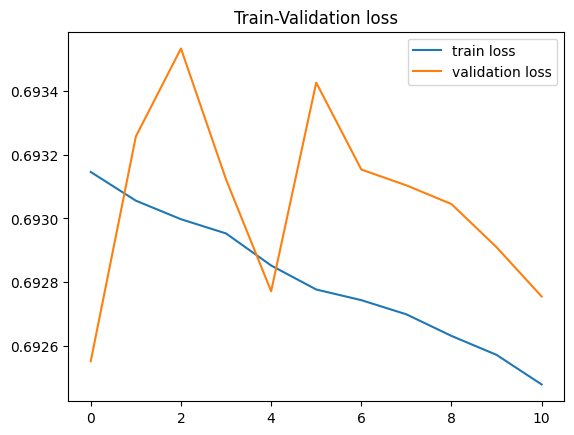

In [25]:
model = lr.LogisticRegressionDep(sequence_max_len=max_sequence_len,lstm_hidden_dim=128,dep_vocab=vocab_dep).to(device)
optimizer = AdamW(model.parameters(), lr=learning_rate,weight_decay=0.1)


save_path=f'm1_{encoding_type}_lr_to2'
train.train_function(model,num_epochs,dl_train['to'],optimizer,early_stop=10,dl_val=dl_val['to'],save_path=save_path,es_threshold=0)

In [26]:
model = lr.LogisticRegressionDep(sequence_max_len=max_sequence_len,lstm_hidden_dim=128,dep_vocab=vocab_dep).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
   
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = train.eval_func(model,dl_eval[task])
    generic.update_global_metric(metric_result,global_metrics[task]['global'])
    print(f"GLOBAL: {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='male')
    generic.update_global_metric(metric_result,global_metrics[task]['male'])
    print(f"MALE {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='female')
    generic.update_global_metric(metric_result,global_metrics[task]['female'])
    print(f"FEMALE {metric_result}",'\n')

Evaluación en el conjunto el conjunto about
GLOBAL: {'recall': 0.5102040816326531, 'precision': 0.5102040816326531, 'f1': 0.5102040816326531, 'accuracy': 0.5102040816326531}
MALE {'recall': 0.0, 'precision': 0.0, 'f1': 0.0, 'accuracy': 0.0}
FEMALE {'recall': 1.0, 'precision': 1.0, 'f1': 1.0, 'accuracy': 1.0} 

Evaluación en el conjunto el conjunto to
GLOBAL: {'recall': 0.4823232323232323, 'precision': 0.4823232323232323, 'f1': 0.4823232323232323, 'accuracy': 0.4823232323232323}
MALE {'recall': 0.0024330900243309003, 'precision': 0.0024330900243309003, 'f1': 0.0024330900243309003, 'accuracy': 0.0024330900243309003}
FEMALE {'recall': 1.0, 'precision': 1.0, 'f1': 1.0, 'accuracy': 1.0} 

Evaluación en el conjunto el conjunto as
GLOBAL: {'recall': 0.4810951760104302, 'precision': 0.4810951760104302, 'f1': 0.4810951760104302, 'accuracy': 0.4810951760104302}
MALE {'recall': 0.0, 'precision': 0.0, 'f1': 0.0, 'accuracy': 0.0}
FEMALE {'recall': 0.9946091644204852, 'precision': 0.9946091644204852

  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.69313467203117 	 Validation loss: 0.6928128428378347 	 
  1%|          | 574/57400 [00:09<14:39, 64.62it/s]
Epoch 2 	 Training loss: 0.6930834438119616 	 Validation loss: 0.6929863014463651 	 

1 epoch without improvement
  2%|▏         | 1148/57400 [00:19<14:51, 63.12it/s]
Epoch 3 	 Training loss: 0.6929736071970405 	 Validation loss: 0.6928410671525083 	 

2 epoch without improvement
  3%|▎         | 1722/57400 [00:29<14:51, 62.48it/s]
Epoch 4 	 Training loss: 0.6928574796960745 	 Validation loss: 0.6931747642614073 	 

3 epoch without improvement
  4%|▍         | 2296/57400 [00:39<14:41, 62.48it/s]
Epoch 5 	 Training loss: 0.6928379172232093 	 Validation loss: 0.6930110323227058 	 

4 epoch without improvement
  5%|▌         | 2870/57400 [00:49<14:23, 63.14it/s]
Epoch 6 	 Training loss: 0.6927440189318375 	 Validation loss: 0.6922316066289352 	 
  6%|▌         | 3444/57400 [00:59<14:30, 61.99it/s]
Epoch 7 	 Training loss: 0.6927108496739058 	 Validation lo

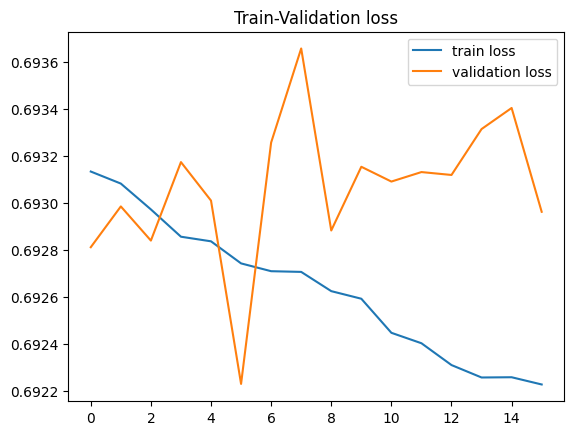

In [27]:
model = lr.LogisticRegressionDep(sequence_max_len=max_sequence_len,lstm_hidden_dim=128,dep_vocab=vocab_dep).to(device)
optimizer = AdamW(model.parameters(), lr=learning_rate,weight_decay=0.1)


save_path=f'm1_{encoding_type}_lr_to3'
train.train_function(model,num_epochs,dl_train['to'],optimizer,early_stop=10,dl_val=dl_val['to'],save_path=save_path,es_threshold=0)

In [28]:
model = lr.LogisticRegressionDep(sequence_max_len=max_sequence_len,lstm_hidden_dim=128,dep_vocab=vocab_dep).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
   
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = train.eval_func(model,dl_eval[task])
    generic.update_global_metric(metric_result,global_metrics[task]['global'])
    print(f"GLOBAL: {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='male')
    generic.update_global_metric(metric_result,global_metrics[task]['male'])
    print(f"MALE {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='female')
    generic.update_global_metric(metric_result,global_metrics[task]['female'])
    print(f"FEMALE {metric_result}",'\n')

Evaluación en el conjunto el conjunto about
GLOBAL: {'recall': 0.514030612244898, 'precision': 0.514030612244898, 'f1': 0.514030612244898, 'accuracy': 0.514030612244898}
MALE {'recall': 0.07552083333333333, 'precision': 0.07552083333333333, 'f1': 0.07552083333333333, 'accuracy': 0.07552083333333333}
FEMALE {'recall': 0.935, 'precision': 0.935, 'f1': 0.935, 'accuracy': 0.935} 

Evaluación en el conjunto el conjunto to
GLOBAL: {'recall': 0.5113636363636364, 'precision': 0.5113636363636364, 'f1': 0.5113636363636364, 'accuracy': 0.5113636363636364}
MALE {'recall': 0.09732360097323602, 'precision': 0.09732360097323602, 'f1': 0.09732360097323602, 'accuracy': 0.09732360097323602}
FEMALE {'recall': 0.958005249343832, 'precision': 0.958005249343832, 'f1': 0.958005249343832, 'accuracy': 0.958005249343832} 

Evaluación en el conjunto el conjunto as
GLOBAL: {'recall': 0.4980443285528031, 'precision': 0.4980443285528031, 'f1': 0.4980443285528031, 'accuracy': 0.4980443285528031}
MALE {'recall': 0.08

In [29]:

print('Métricas globales: \n')

for task in ['about','to','as']:
    print('\n',task)
    print('Resultado global:',{m:mean(values) for m,values in global_metrics[task]['global'].items()})
    print(f'Métricas etiqueta male:',{m:mean(values) for m,values in global_metrics[task]['male'].items()})
    print('Métricas etiqueta female: ',{m:mean(values) for m,values in global_metrics[task]['female'].items()})


Métricas globales: 


 about
Resultado global: {'recall': 0.514030612244898, 'precision': 0.514030612244898, 'f1': 0.514030612244898, 'accuracy': 0.514030612244898}
Métricas etiqueta male: {'recall': 0.0685763888888889, 'precision': 0.0685763888888889, 'f1': 0.0685763888888889, 'accuracy': 0.0685763888888889}
Métricas etiqueta female:  {'recall': 0.9416666666666667, 'precision': 0.9416666666666667, 'f1': 0.9416666666666667, 'accuracy': 0.9416666666666667}

 to
Resultado global: {'recall': 0.5088383838383839, 'precision': 0.5088383838383839, 'f1': 0.5088383838383839, 'accuracy': 0.5088383838383839}
Métricas etiqueta male: {'recall': 0.0948905109489051, 'precision': 0.0948905109489051, 'f1': 0.0948905109489051, 'accuracy': 0.0948905109489051}
Métricas etiqueta female:  {'recall': 0.9553805774278216, 'precision': 0.9553805774278216, 'f1': 0.9553805774278215, 'accuracy': 0.9553805774278216}

 as
Resultado global: {'recall': 0.49630595393307253, 'precision': 0.49630595393307253, 'f1': 0.496

# AS

In [30]:
max_sequence_len = 15088
learning_rate = 5e-5
num_epochs = 100

global_metrics = {'about':{'global':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'male':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'female':{'recall': [], 'precision': [],'f1': [], 'accuracy': []}},
                    'as':{'global':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'male':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'female':{'recall': [], 'precision': [],'f1': [], 'accuracy': []}},
                    'to':{'global':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'male':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'female':{'recall': [], 'precision': [],'f1': [], 'accuracy': []}}}

  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6930851741119545 	 Validation loss: 0.693401747840946 	 
  1%|          | 574/57400 [00:09<14:48, 63.99it/s]
Epoch 2 	 Training loss: 0.6928969518855889 	 Validation loss: 0.6929737541635158 	 
  2%|▏         | 1148/57400 [00:19<14:25, 64.97it/s]
Epoch 3 	 Training loss: 0.6927520514365273 	 Validation loss: 0.6932909417960603 	 

1 epoch without improvement
  3%|▎         | 1722/57400 [00:29<15:03, 61.65it/s]
Epoch 4 	 Training loss: 0.6925408175598038 	 Validation loss: 0.6926298373836582 	 
  4%|▍         | 2296/57400 [00:39<14:31, 63.21it/s]
Epoch 5 	 Training loss: 0.6923518094659267 	 Validation loss: 0.6929740148075556 	 

1 epoch without improvement
  5%|▌         | 2870/57400 [00:49<14:38, 62.06it/s]
Epoch 6 	 Training loss: 0.692158351999542 	 Validation loss: 0.6925647390090813 	 
  6%|▌         | 3444/57400 [00:59<14:49, 60.66it/s]
Epoch 7 	 Training loss: 0.6920150021019713 	 Validation loss: 0.6926578525769509 	 

1 epoch without improvement
  7

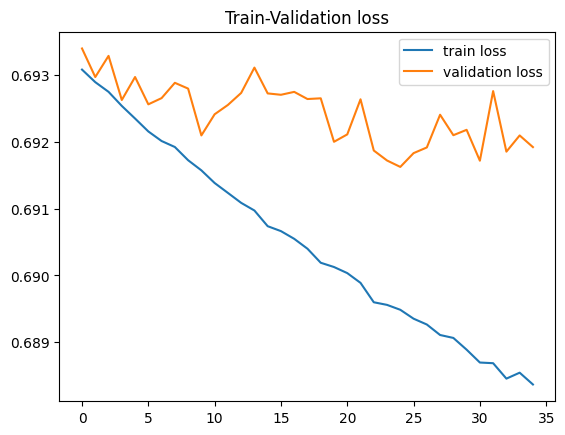

In [31]:
model = lr.LogisticRegressionDep(sequence_max_len=max_sequence_len,lstm_hidden_dim=128,dep_vocab=vocab_dep).to(device)
optimizer = AdamW(model.parameters(), lr=learning_rate,weight_decay=0.1)


save_path=f'm1_{encoding_type}_lr_as1'
train.train_function(model,num_epochs,dl_train['as'],optimizer,early_stop=10,dl_val=dl_val['as'],save_path=save_path,es_threshold=0)

In [32]:
model = lr.LogisticRegressionDep(sequence_max_len=max_sequence_len,lstm_hidden_dim=128,dep_vocab=vocab_dep).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
   
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = train.eval_func(model,dl_eval[task])
    generic.update_global_metric(metric_result,global_metrics[task]['global'])
    print(f"GLOBAL: {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='male')
    generic.update_global_metric(metric_result,global_metrics[task]['male'])
    print(f"MALE {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='female')
    generic.update_global_metric(metric_result,global_metrics[task]['female'])
    print(f"FEMALE {metric_result}",'\n')

Evaluación en el conjunto el conjunto about
GLOBAL: {'recall': 0.4987244897959184, 'precision': 0.4987244897959184, 'f1': 0.4987244897959184, 'accuracy': 0.4987244897959184}
MALE {'recall': 0.3333333333333333, 'precision': 0.3333333333333333, 'f1': 0.3333333333333333, 'accuracy': 0.3333333333333333}
FEMALE {'recall': 0.6575, 'precision': 0.6575, 'f1': 0.6575, 'accuracy': 0.6575} 

Evaluación en el conjunto el conjunto to
GLOBAL: {'recall': 0.5580808080808081, 'precision': 0.5580808080808081, 'f1': 0.5580808080808081, 'accuracy': 0.5580808080808081}
MALE {'recall': 0.4233576642335766, 'precision': 0.4233576642335766, 'f1': 0.4233576642335766, 'accuracy': 0.4233576642335766}
FEMALE {'recall': 0.7034120734908137, 'precision': 0.7034120734908137, 'f1': 0.7034120734908137, 'accuracy': 0.7034120734908137} 

Evaluación en el conjunto el conjunto as
GLOBAL: {'recall': 0.576271186440678, 'precision': 0.576271186440678, 'f1': 0.576271186440678, 'accuracy': 0.576271186440678}
MALE {'recall': 0.38

  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6930969254688103 	 Validation loss: 0.693097981355958 	 
  1%|          | 574/57400 [00:09<14:52, 63.65it/s]
Epoch 2 	 Training loss: 0.6929217703666422 	 Validation loss: 0.6930813890392498 	 
  2%|▏         | 1148/57400 [00:20<15:12, 61.62it/s]
Epoch 3 	 Training loss: 0.6927213102890639 	 Validation loss: 0.6927405757419134 	 
  3%|▎         | 1722/57400 [00:31<15:56, 58.24it/s]
Epoch 4 	 Training loss: 0.69257077585114 	 Validation loss: 0.6929177136744483 	 

1 epoch without improvement
  4%|▍         | 2296/57400 [00:41<14:34, 63.03it/s]
Epoch 5 	 Training loss: 0.692381598704368 	 Validation loss: 0.6926947892722437 	 
  5%|▌         | 2870/57400 [00:51<14:34, 62.37it/s]
Epoch 6 	 Training loss: 0.6921935885210071 	 Validation loss: 0.6927395553912147 	 

1 epoch without improvement
  6%|▌         | 3444/57400 [01:02<14:30, 62.00it/s]
Epoch 7 	 Training loss: 0.6920119939365453 	 Validation loss: 0.6926889106378717 	 
  7%|▋         | 4018/57400 [01:12

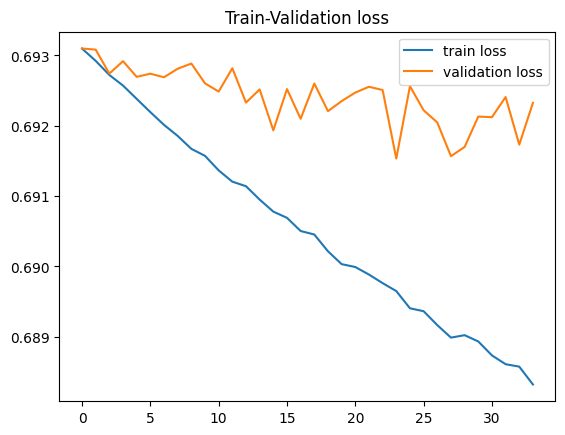

In [33]:
model = lr.LogisticRegressionDep(sequence_max_len=max_sequence_len,lstm_hidden_dim=128,dep_vocab=vocab_dep).to(device)
optimizer = AdamW(model.parameters(), lr=learning_rate,weight_decay=0.1)


save_path=f'm1_{encoding_type}_lr_as2'
train.train_function(model,num_epochs,dl_train['as'],optimizer,early_stop=10,dl_val=dl_val['as'],save_path=save_path,es_threshold=0)

In [34]:
model = lr.LogisticRegressionDep(sequence_max_len=max_sequence_len,lstm_hidden_dim=128,dep_vocab=vocab_dep).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
   
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = train.eval_func(model,dl_eval[task])
    generic.update_global_metric(metric_result,global_metrics[task]['global'])
    print(f"GLOBAL: {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='male')
    generic.update_global_metric(metric_result,global_metrics[task]['male'])
    print(f"MALE {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='female')
    generic.update_global_metric(metric_result,global_metrics[task]['female'])
    print(f"FEMALE {metric_result}",'\n')

Evaluación en el conjunto el conjunto about
GLOBAL: {'recall': 0.46683673469387754, 'precision': 0.46683673469387754, 'f1': 0.46683673469387754, 'accuracy': 0.46683673469387754}
MALE {'recall': 0.3203125, 'precision': 0.3203125, 'f1': 0.3203125, 'accuracy': 0.3203125}
FEMALE {'recall': 0.6075, 'precision': 0.6075, 'f1': 0.6075, 'accuracy': 0.6075} 

Evaluación en el conjunto el conjunto to
GLOBAL: {'recall': 0.5833333333333334, 'precision': 0.5833333333333334, 'f1': 0.5833333333333334, 'accuracy': 0.5833333333333334}
MALE {'recall': 0.48661800486618007, 'precision': 0.48661800486618007, 'f1': 0.48661800486618007, 'accuracy': 0.48661800486618007}
FEMALE {'recall': 0.6876640419947506, 'precision': 0.6876640419947506, 'f1': 0.6876640419947506, 'accuracy': 0.6876640419947506} 

Evaluación en el conjunto el conjunto as
GLOBAL: {'recall': 0.5919165580182529, 'precision': 0.5919165580182529, 'f1': 0.5919165580182529, 'accuracy': 0.5919165580182529}
MALE {'recall': 0.4015151515151515, 'precisi

  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6931047572491477 	 Validation loss: 0.6929182895159317 	 
  1%|          | 574/57400 [00:10<15:25, 61.43it/s]
Epoch 2 	 Training loss: 0.6928941656280477 	 Validation loss: 0.692431899450593 	 
  2%|▏         | 1148/57400 [00:20<15:06, 62.07it/s]
Epoch 3 	 Training loss: 0.6927308494205674 	 Validation loss: 0.69320629713899 	 

1 epoch without improvement
  3%|▎         | 1722/57400 [00:30<15:44, 58.93it/s]
Epoch 4 	 Training loss: 0.6925419941804135 	 Validation loss: 0.692892485755985 	 

2 epoch without improvement
  4%|▍         | 2296/57400 [00:41<15:46, 58.19it/s]
Epoch 5 	 Training loss: 0.6923577996288858 	 Validation loss: 0.6925885485390485 	 

3 epoch without improvement
  5%|▌         | 2870/57400 [00:52<15:42, 57.88it/s]
Epoch 6 	 Training loss: 0.6921464814333965 	 Validation loss: 0.6932569166361275 	 

4 epoch without improvement
  6%|▌         | 3444/57400 [01:03<15:29, 58.03it/s]
Epoch 7 	 Training loss: 0.6920434335175292 	 Validation loss

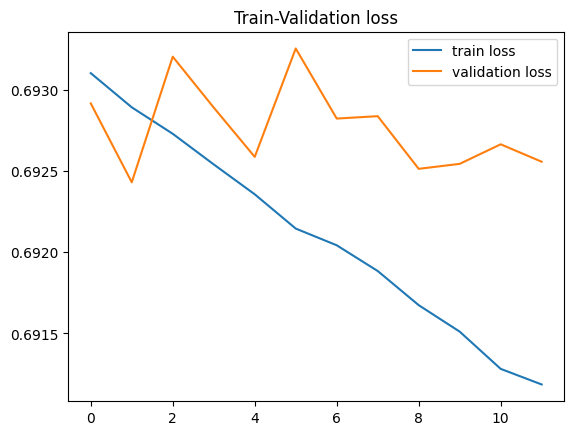

In [35]:
model = lr.LogisticRegressionDep(sequence_max_len=max_sequence_len,lstm_hidden_dim=128,dep_vocab=vocab_dep).to(device)
optimizer = AdamW(model.parameters(), lr=learning_rate,weight_decay=0.1)


save_path=f'm1_{encoding_type}_lr_as3'
train.train_function(model,num_epochs,dl_train['as'],optimizer,early_stop=10,dl_val=dl_val['as'],save_path=save_path,es_threshold=0)

In [36]:
model = lr.LogisticRegressionDep(sequence_max_len=max_sequence_len,lstm_hidden_dim=128,dep_vocab=vocab_dep).to(device)

model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
   
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = train.eval_func(model,dl_eval[task])
    generic.update_global_metric(metric_result,global_metrics[task]['global'])
    print(f"GLOBAL: {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='male')
    generic.update_global_metric(metric_result,global_metrics[task]['male'])
    print(f"MALE {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='female')
    generic.update_global_metric(metric_result,global_metrics[task]['female'])
    print(f"FEMALE {metric_result}",'\n')

Evaluación en el conjunto el conjunto about
GLOBAL: {'recall': 0.5114795918367347, 'precision': 0.5114795918367347, 'f1': 0.5114795918367347, 'accuracy': 0.5114795918367347}
MALE {'recall': 0.010416666666666666, 'precision': 0.010416666666666666, 'f1': 0.010416666666666666, 'accuracy': 0.010416666666666666}
FEMALE {'recall': 0.9925, 'precision': 0.9925, 'f1': 0.9925, 'accuracy': 0.9925} 

Evaluación en el conjunto el conjunto to
GLOBAL: {'recall': 0.4898989898989899, 'precision': 0.4898989898989899, 'f1': 0.4898989898989899, 'accuracy': 0.4898989898989899}
MALE {'recall': 0.021897810218978103, 'precision': 0.021897810218978103, 'f1': 0.021897810218978103, 'accuracy': 0.021897810218978103}
FEMALE {'recall': 0.994750656167979, 'precision': 0.994750656167979, 'f1': 0.994750656167979, 'accuracy': 0.994750656167979} 

Evaluación en el conjunto el conjunto as
GLOBAL: {'recall': 0.4876140808344198, 'precision': 0.4876140808344198, 'f1': 0.4876140808344198, 'accuracy': 0.4876140808344198}
MALE

In [37]:

print('Métricas globales: \n')

for task in ['about','to','as']:
    print('\n',task)
    print('Resultado global:',{m:mean(values) for m,values in global_metrics[task]['global'].items()})
    print(f'Métricas etiqueta male:',{m:mean(values) for m,values in global_metrics[task]['male'].items()})
    print('Métricas etiqueta female: ',{m:mean(values) for m,values in global_metrics[task]['female'].items()})


Métricas globales: 


 about
Resultado global: {'recall': 0.4923469387755102, 'precision': 0.4923469387755102, 'f1': 0.4923469387755102, 'accuracy': 0.4923469387755102}
Métricas etiqueta male: {'recall': 0.22135416666666666, 'precision': 0.22135416666666666, 'f1': 0.22135416666666666, 'accuracy': 0.22135416666666666}
Métricas etiqueta female:  {'recall': 0.7525000000000001, 'precision': 0.7525000000000001, 'f1': 0.7525000000000001, 'accuracy': 0.7525000000000001}

 to
Resultado global: {'recall': 0.5437710437710438, 'precision': 0.5437710437710438, 'f1': 0.5437710437710438, 'accuracy': 0.5437710437710438}
Métricas etiqueta male: {'recall': 0.31062449310624496, 'precision': 0.31062449310624496, 'f1': 0.31062449310624496, 'accuracy': 0.31062449310624496}
Métricas etiqueta female:  {'recall': 0.7952755905511811, 'precision': 0.7952755905511811, 'f1': 0.7952755905511811, 'accuracy': 0.7952755905511811}

 as
Resultado global: {'recall': 0.5519339417644502, 'precision': 0.5519339417644502, '